# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [32]:
import pandas as pd
import numpy as np
import math
import json
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from datetime import datetime, timedelta
from tqdm import tqdm
% matplotlib inline

# read in the json files
portfolio = pd.read_json('/content/drive/MyDrive/Starbucks/portfolio.json', orient='records', lines=True)
profile = pd.read_json('/content/drive/MyDrive/Starbucks/profile.json', orient='records', lines=True)
transcript = pd.read_json('/content/drive/MyDrive/Starbucks/transcript.json', orient='records', lines=True)

## Preliminary Analysis

In [33]:
portfolio.head() #Checking the portfolio file

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7


The portfolio contains 10 different types of offer id's. Each offer has a reward value between 0-10 and difficulty between 0-20 with each offer having a specific channel bundle associated with it which would be ignored in this study as it is out of scope. 

In [35]:
transcript.head()#Checking the transcript file

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


Transcript is the table where the user behaviour and interactions with offers lie.

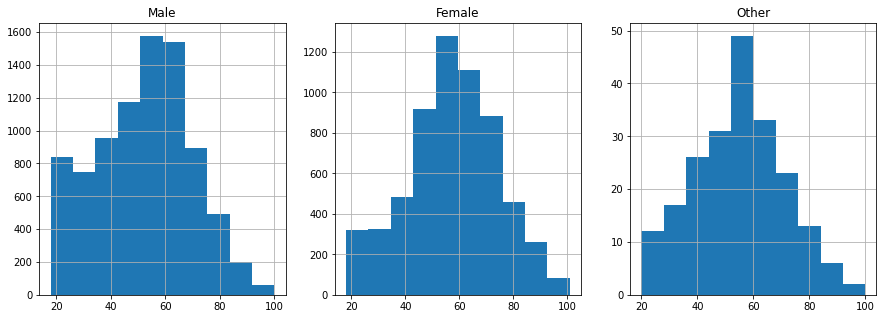

In [36]:
#Visualizing portfolio demographics
fig = plt.figure(figsize=(15,5))
ax1 = fig.add_subplot(131)
ax1 = profile[profile['gender']=='M']['age'].hist()
ax2 = fig.add_subplot(132)
ax2= profile[profile['gender']=='F']['age'].hist()
ax3 = fig.add_subplot(133)
ax3= profile[profile['gender']=='O']['age'].hist()
ax1.title.set_text('Male')
ax2.title.set_text('Female')
ax3.title.set_text('Other')

There is an age similarity across all genders with the total number of male users being higher.

In [37]:
transcript['event'].unique()#showing event types

array(['offer received', 'offer viewed', 'transaction', 'offer completed'],
      dtype=object)

## Data Cleaning

In [88]:
portfolio_clean = pd.concat((portfolio,pd.get_dummies(portfolio['offer_type'])), axis=1)#.drop(columns=['offer_type'],axis=0)

In [39]:
#Renaming columns
portfolio_clean.rename(columns={'channels':'offer_channels',
                                'difficulty':'offer_difficulty',
                               'id':'offer_id',
                               'reward':'offer_reward',
                               'bogo':'offer_bogo',
                               'discount':'offer_discount',
                               'informational':'offer_info'},inplace=True)

In [40]:
portfolio_clean.head(10) #New data visualization

,offer_reward,offer_channels,offer_difficulty,duration,offer_type,offer_id,offer_bogo,offer_discount,offer_info
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,1,0,0
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1,0,0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed,0,0,1
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,0,0
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,1,0
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2,0,1,0
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4,0,1,0
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837,0,0,1
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d,1,0,0
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5,0,1,0


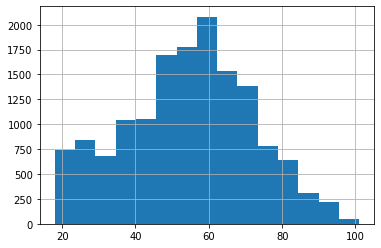

In [41]:
#Removing outliers
profile_clean = profile.copy()
profile_clean['age'] = profile_clean['age'].apply(lambda x: np.nan if x == 118 else x)
profile_clean['age'].hist(bins=15)

For this project, I will be deriving conclusions based on the demographics data. 

In [42]:
#Dropping unnecessary columns
profile_clean = profile_clean[(profile_clean['age'].notnull()) & (profile_clean['gender'].notnull()) & (profile_clean['income'].notnull())]
profile_clean.head(3)

,gender,age,id,became_member_on,income
1,F,55.0,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
3,F,75.0,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
5,M,68.0,e2127556f4f64592b11af22de27a7932,20180426,70000.0


In [45]:
profile_clean['became_member_on'] = profile_clean['became_member_on'].apply(lambda x: datetime(year=int(str(x)[0:4]), month=int(str(x)[4:6]), day=int(str(x)[6:8])))

In [46]:
profile_clean=profile_clean.drop_duplicates()#Removing duplicates

In [47]:
profile_distribution = profile_clean.groupby(by=['gender','age'])['id'].nunique().unstack().transpose()#Grouping
profile_distribution.head()

gender,F,M,O
age,,,
18.0,14.0,56.0,NaN
19.0,31.0,104.0,NaN
20.0,35.0,96.0,4.0
21.0,41.0,96.0,3.0
22.0,46.0,84.0,1.0


In [48]:
profile_distribution = profile_clean.groupby(by=['gender','age'])['id'].nunique().unstack().transpose()#Grouping
profile_distribution.head()

gender,F,M,O
age,,,
18.0,14.0,56.0,NaN
19.0,31.0,104.0,NaN
20.0,35.0,96.0,4.0
21.0,41.0,96.0,3.0
22.0,46.0,84.0,1.0


In [49]:
#Investigating transaction types
transaction_types=set()
transcript['value'].apply(lambda x: list(x.keys()))
for i in range(transcript['value'].shape[0]):
    for transaction in list(transcript['value'].iloc[i].keys()):
        transaction_types.add(transaction)
transaction_types

{'amount', 'offer id', 'offer_id', 'reward'}

Trying to understand the different types of transactions listed, I have discovered that there are values for "offer_id" and "offer id" which should be merged.

In [52]:
values = transcript['value'].apply(pd.Series)

In [53]:
values['offer_id'] = np.logical_or(values['offer id'].fillna(0),values['offer_id'].fillna(0)) 
values = values.drop(['offer id'],axis=1)

In [54]:
transcript_clean = pd.concat([transcript,values],axis=1,sort=False).drop(['value','reward'],axis=1)

In [55]:
transcript_clean.head(3)

,person,event,time,amount,offer_id
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7
2,e2127556f4f64592b11af22de27a7932,offer received,0,NaN,2906b810c7d4411798c6938adc9daaa5


In [56]:
transcript_clean.rename(columns={'person':'id'},inplace=True)

In [57]:
transcript_clean=transcript_clean.drop_duplicates()
transcript_clean.head(3)

,id,event,time,amount,offer_id
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7
2,e2127556f4f64592b11af22de27a7932,offer received,0,NaN,2906b810c7d4411798c6938adc9daaa5


In [58]:
transcript_clean[transcript_clean['event']=='transaction'].head(3)

,id,event,time,amount,offer_id
12654,02c083884c7d45b39cc68e1314fec56c,transaction,0,0.83,0
12657,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,transaction,0,34.56,0
12659,54890f68699049c2a04d415abc25e717,transaction,0,13.23,0


#### Data Transformation

In [59]:
transcript_df = transcript_clean.merge(profile_clean,how='inner',on=['id']).merge(
    portfolio_clean,how='outer',on=['offer_id'])
transcript_df.head(3)

,id,event,time,amount,offer_id,gender,age,became_member_on,income,offer_reward,offer_channels,offer_difficulty,duration,offer_type,offer_bogo,offer_discount,offer_info
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,F,75.0,2017-05-09,100000.0,5.0,"[web, email, mobile]",5.0,7.0,bogo,1.0,0.0,0.0
1,78afa995795e4d85b5d9ceeca43f5fef,offer viewed,6,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,F,75.0,2017-05-09,100000.0,5.0,"[web, email, mobile]",5.0,7.0,bogo,1.0,0.0,0.0
2,78afa995795e4d85b5d9ceeca43f5fef,offer completed,132,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,F,75.0,2017-05-09,100000.0,5.0,"[web, email, mobile]",5.0,7.0,bogo,1.0,0.0,0.0


## Data Analysis

Before going into demographics, I would like to look into overall performance of offers by checking the number of times each offer was sent out and ended up being completed.

In [60]:
received = transcript_clean[transcript_clean['event']=='offer received'].drop(columns=['amount','event'])
viewed = transcript_clean[transcript_clean['event']=='offer viewed'].drop(columns=['amount','event'])
completed = transcript_clean[transcript_clean['event']=='offer completed'].drop(columns=['amount','event'])
transaction = transcript_clean[transcript_clean['event']=='transaction']

### Offer Distribution

<BarContainer object of 10 artists>

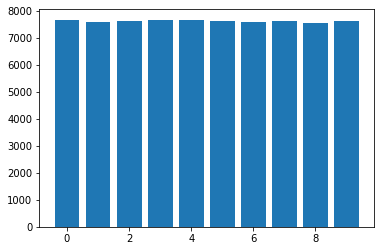

In [61]:
receive_counts = received['offer_id'].value_counts().to_frame().reset_index().rename(columns={'offer_id':'receive_count','index':'offer_id'})
offer_receive_counts=portfolio_clean.merge(receive_counts,how='left',on=['offer_id'])#[['offer_id','receive_count']]
plt.bar(range(10),offer_receive_counts['receive_count'])

Balanced distribution confirmed.

In [62]:
view_counts = viewed['offer_id'].value_counts().to_frame().reset_index().rename(columns={'offer_id':'view_count','index':'offer_id'})
offer_view_counts=portfolio_clean.merge(view_counts,how='left',on=['offer_id'])#[['offer_id','view_count','offer_type']]
viewed.rename(columns={'time':'time_viewed'},inplace=True)

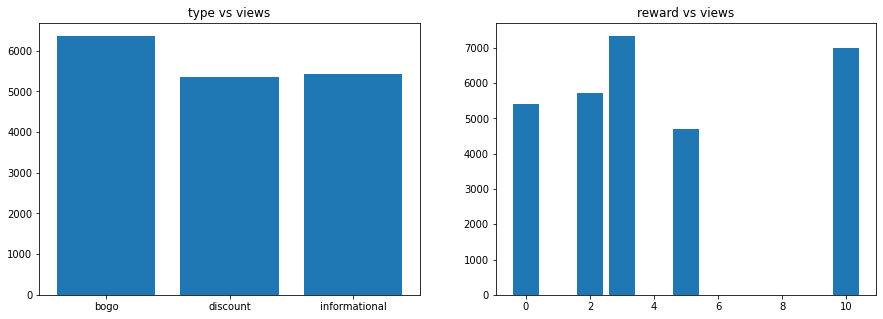

In [63]:
fig = plt.figure(figsize=(15,5))
ax1 = fig.add_subplot(121)
ax1.set_title('type vs views')
ax1 = plt.bar(offer_view_counts.groupby(['offer_type'])['view_count'].mean().keys(), offer_view_counts.groupby(['offer_type'])['view_count'].mean().values)
ax2 = fig.add_subplot(122)
ax2.set_title('reward vs views')
ax2= plt.bar(offer_view_counts.groupby(['offer_reward'])['view_count'].mean().keys(), offer_view_counts.groupby(['offer_reward'])['view_count'].mean().values)

It is shown that on average the BOGO offers are viewed ~%20 more than others.

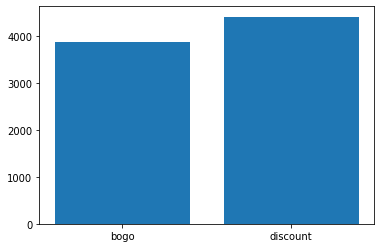

In [64]:
complete_counts = completed['offer_id'].value_counts().to_frame().reset_index().rename(columns={'offer_id':'complete_count','index':'offer_id'})
offer_complete_counts = portfolio_clean.merge(complete_counts,how='left',on=['offer_id'])
completed.rename(columns={'time':'time_completed'},inplace=True)
ax1= plt.bar(offer_complete_counts.groupby(['offer_type'])['complete_count'].mean().keys(), offer_complete_counts.groupby(['offer_type'])['complete_count'].mean().values)

But on here, the discount offers are completed slightly more even though bogo offers are viewed more. Could this be intentional?


To understand the timeline each received offer, we would calculate the beginning and end of each offer. In order to do so, we need to get the duration information from the portfolio dataframe by merging them.

I would create a dictionary that holds duration information for each offer id and apply it inside a lambda function to obtain the end date of an offer.

In [65]:
duration_dictionary = dict()
for offer in list(portfolio_clean['offer_id']):
    duration_dictionary[offer]= portfolio_clean[portfolio_clean['offer_id']==offer]['duration'].values[0]
duration_dictionary

{'0b1e1539f2cc45b7b9fa7c272da2e1d7': 10,
 '2298d6c36e964ae4a3e7e9706d1fb8c2': 7,
 '2906b810c7d4411798c6938adc9daaa5': 7,
 '3f207df678b143eea3cee63160fa8bed': 4,
 '4d5c57ea9a6940dd891ad53e9dbe8da0': 5,
 '5a8bc65990b245e5a138643cd4eb9837': 3,
 '9b98b8c7a33c4b65b9aebfe6a799e6d9': 7,
 'ae264e3637204a6fb9bb56bc8210ddfd': 7,
 'f19421c1d4aa40978ebb69ca19b0e20d': 5,
 'fafdcd668e3743c1bb461111dcafc2a4': 10}

In [66]:
received['end_time']=0
received.rename(columns={'time':'start_time'},inplace=True)
received.head()

,id,start_time,offer_id,end_time
0,78afa995795e4d85b5d9ceeca43f5fef,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0
1,a03223e636434f42ac4c3df47e8bac43,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0
2,e2127556f4f64592b11af22de27a7932,0,2906b810c7d4411798c6938adc9daaa5,0
3,8ec6ce2a7e7949b1bf142def7d0e0586,0,fafdcd668e3743c1bb461111dcafc2a4,0
4,68617ca6246f4fbc85e91a2a49552598,0,4d5c57ea9a6940dd891ad53e9dbe8da0,0


In [67]:
received['end_time']=received.apply(
    lambda x: duration_dictionary[x['offer_id']]*24 + x['start_time'],axis=1)
received.head(3)

,id,start_time,offer_id,end_time
0,78afa995795e4d85b5d9ceeca43f5fef,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,168
1,a03223e636434f42ac4c3df47e8bac43,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,240
2,e2127556f4f64592b11af22de27a7932,0,2906b810c7d4411798c6938adc9daaa5,168


In [69]:
df = received.merge(
    viewed,how='outer',on=['id','offer_id'],suffixes=('','_viewed')).merge(
    completed,how='outer',on=['id','offer_id'],suffixes=('','_completed'))

In [70]:
def transactions_complete(df,profile):
    
    output_df=pd.DataFrame()
    user_list = profile['id'].unique()
    
    for user in tqdm(user_list):
        temp_df = df[df['id']==user]
        temp_df=temp_df[
            (temp_df['end_time'] >= temp_df['time_completed']) &
            (temp_df['time_completed'] >=temp_df['time_viewed']) & 
            (temp_df['time_viewed']>=temp_df['start_time'])].sort_values(
                            by=['start_time','time_viewed','time_completed'])
        
        #We will first fill the initial offer even if same offer_ids are sent really close
        temp_df.drop_duplicates(subset=['start_time'], inplace=True) 
        
        temp_df.drop_duplicates(subset=['offer_id','time_completed'], inplace=True)
        
        output_df = output_df.append(temp_df)
    return output_df

In [71]:
completes = transactions_complete(df,profile_clean)

100%|██████████| 14825/14825 [06:07<00:00, 40.35it/s]


Now that we know obtained succesfully completed offers.

In [72]:
total_completes = completed.shape[0]
number_of_completes = completes.shape[0]
number_of_incompletes = total_completes-number_of_completes
print(str(total_completes), '=' ,str(number_of_incompletes), '+',str(completes.shape[0]))

33182 = 10649 + 22533


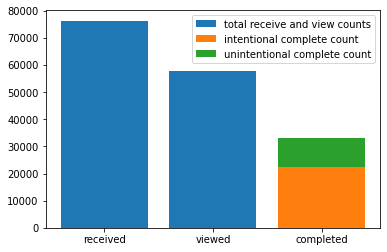

In [75]:
plt.bar(['received','viewed','completed'],[received.shape[0],viewed.shape[0],0],label='total receive and view counts')
plt.bar(['received','viewed','completed'],[0,0,number_of_completes],label='intentional complete count')
plt.bar(['received','viewed','completed'],[0,0,number_of_incompletes],bottom=[0,0,number_of_completes],label='unintentional complete count')
plt.legend()

From these numbers, ~1/3 of the completed offers are not even viewed by the user on time which means that Starbucks made offers to users who are already going to make the purchases.

In [77]:
temp_df = completed.merge(
    completes,how='left',on=['offer_id','id','time_completed'])
unintentional_completes= temp_df[temp_df['start_time'].isnull()][['offer_id','id','time_completed']]

In [78]:
offer_received_counts = received['offer_id'].value_counts().to_frame().reset_index().rename(columns={'offer_id':'receive_count','index':'offer_id'})
offer_complete_counts = completes['offer_id'].value_counts().to_frame().reset_index().rename(columns={'offer_id':'intentional_completes','index':'offer_id'})
offer_unintentional_complete_counts = unintentional_completes['offer_id'].value_counts().to_frame().reset_index().rename(columns={'offer_id':'nonintentional_completes','index':'offer_id'})

### Demographics

In [79]:
completes_df = completes.merge(
    profile_clean,on=['id'],how='left').merge(
    portfolio_clean,on=['offer_id'],how='left')

<BarContainer object of 3 artists>

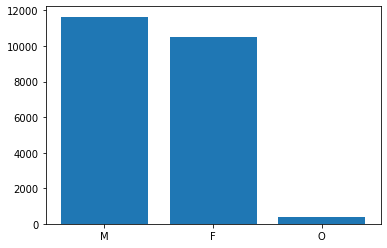

In [80]:
plt.bar(completes_df['gender'].value_counts().keys(),
        completes_df['gender'].value_counts().values)

In [81]:
gender_count = [profile_clean[profile_clean['gender']=='M'].shape[0],profile_clean[profile_clean['gender']=='F'].shape[0],profile_clean[profile_clean['gender']=='O'].shape[0]]
gender_count

[8484, 6129, 212]

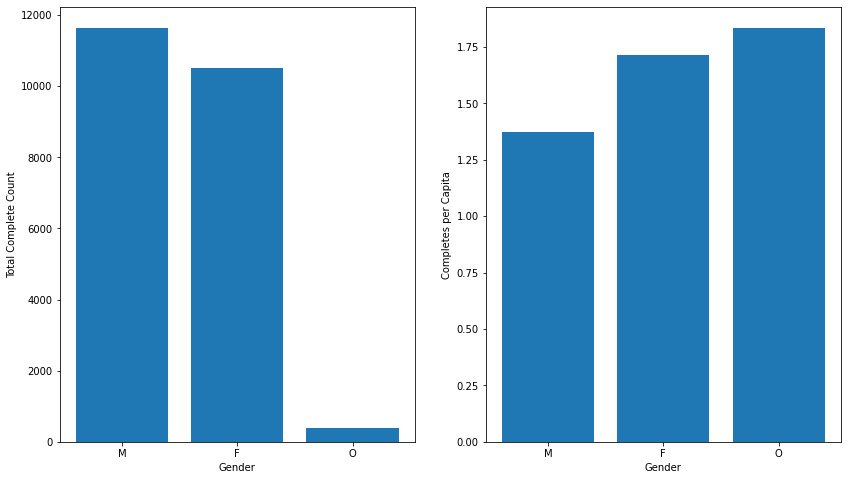

In [82]:
plt.figure(figsize=(14,8))
ax1 = plt.subplot(1,2,1)
ax1=plt.xlabel('Gender')
ax1=plt.ylabel('Total Complete Count')
ax1= plt.bar(completes_df['gender'].value_counts().keys(),
        completes_df['gender'].value_counts().values)
ax2 = plt.subplot(1,2,2)
ax2=plt.xlabel('Gender')
ax2=plt.ylabel('Completes per Capita')
ax2=plt.bar(completes_df['gender'].value_counts().keys(),
        completes_df['gender'].value_counts().values/gender_count)

Total number of completed offerd are higher for males, but when normalized with number of customers in database, we see that they are larger across the other and female customers.

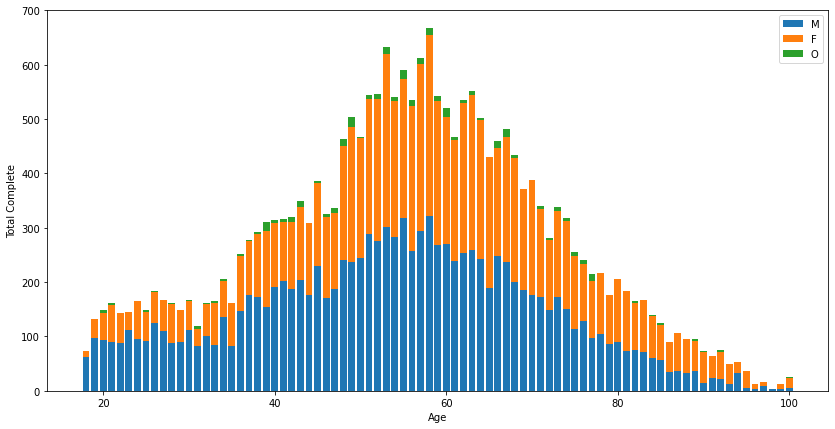

In [83]:
dem_total = completes_df.groupby(by=['gender','age'])['id'].size().unstack().transpose()
plt.figure(figsize=(14,7))
plt.bar(dem_total['M'].keys(),dem_total['M'].values,label='M')
plt.bar(dem_total['F'].keys(),dem_total['F'].values,bottom=dem_total['M'].values,label='F')
plt.bar(dem_total['O'].keys(),dem_total['O'].values,bottom=dem_total['M'].values+dem_total['F'].values,label='O')
plt.xlabel('Age')
plt.ylabel('Total Complete')
plt.legend()

This distribution shows the total number completed offers and it points towards the 50-60 age demographic being the majority with the most completed offers.

### Demographics by income

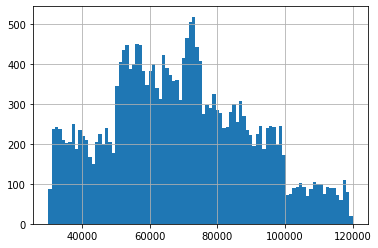

In [85]:
income = np.sort(list(completes_df['income'].unique()))
completes_df['income'].hist(bins=len(income))

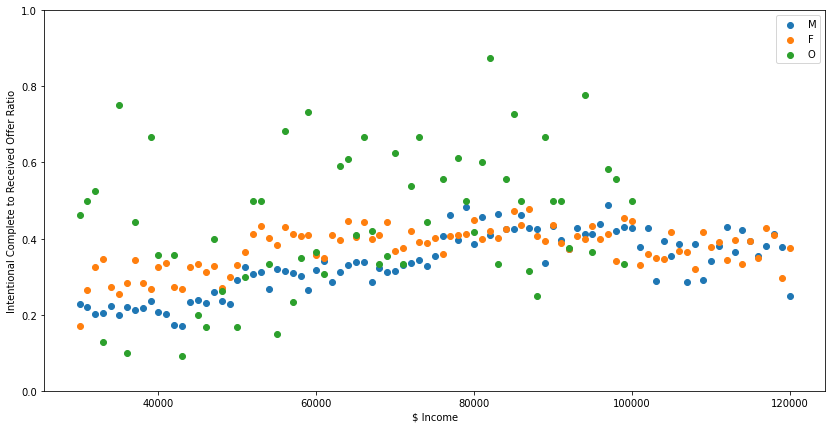

In [87]:
total_by_income = completes_df.groupby(
    by=['income','gender'])['id'].size().unstack()

received_income = received.merge(profile_clean,on=['id'],how='left').groupby(
    by=['income','gender'])['id'].size().unstack()
plt.figure(figsize=(14,7))

for gender in ['M','F','O']:
    completed_by_income = total_by_income[gender]/received_income[gender]
    x_data = completed_by_income.keys()
    y_data = completed_by_income.values
    a = plt.scatter(x_data,y_data,label=gender)
    plt.ylim(0,1)
    plt.xlabel('$ Income')
    plt.ylabel('Intentional Complete to Received Offer Ratio')
    plt.legend()

 The other gender labelled O has incomplete data which results in its analysis being inconclusive. 

There is higher number of completed offers for income levels in between $50-70k, especially for female customers.

For income levels below $50,000 male customers make up more of the completed offer compared to female customers.
